In [1]:
import os
import pandas as pd
import numpy  as np
from scipy.fft    import dct, idct
from scipy.signal import butter, savgol_filter, ellip, filtfilt, detrend
from matplotlib   import pylab as plt

## Loading data

In [2]:
# paths were the raw data is
root_path = 'data/'
data_path = os.path.join(root_path, 'Experiment')
shimmer_path  = os.path.join(data_path, 'shimmer')

# paths were the preprocessed data should be
out_path = os.path.join(root_path, 'Processed')
eda_out_path = os.path.join(out_path, 'EDA')

# check if the output folders exist and create them if necessary
for folder in [out_path, eda_out_path]:
    if not os.path.exists(folder):
        os.mkdir(folder)

# list all files (ignoring the hidden macos file)
shimmer_files = [x for x in os.listdir(shimmer_path) if x.endswith('.csv')]

In [3]:
shimmer_files

['04_EDA_SS2023_Exp1_Session1_Shimmer_D210_Calibrated_SD.csv',
 '02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv',
 '04_EMG_SS2023_Exp1_Session1_Shimmer_EC93_Calibrated_SD.csv',
 'Trigger_SS2023_Exp1_Session1_Shimmer_895A_Calibrated_SD.csv',
 '03_EDA_SS2023_Exp1_Session1_Shimmer_86D4_Calibrated_SD.csv',
 '03_EMG_SS2023_Exp1_Session1_Shimmer_EC8E_Calibrated_SD.csv',
 '01_EMG_SS2023_Exp1_Session1_Shimmer_F0BA_Calibrated_SD.csv']

In [4]:
eda_path = shimmer_files[0]
trigger_shimmer = shimmer_files[3]

In [5]:
eda_path, trigger_shimmer

('04_EDA_SS2023_Exp1_Session1_Shimmer_D210_Calibrated_SD.csv',
 'Trigger_SS2023_Exp1_Session1_Shimmer_895A_Calibrated_SD.csv')

## Preprocessing

In [6]:
# Reshape a numpy array 'a' of shape (n, x) to form shape((n - window_size), window_size, x))
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [7]:
def filterTonicEDA(signal, coarsest=2):
    X        = dct(signal) # discrete cosine transform
    absX     = np.abs(X)   # keep magnitude only
    absX[::-1].sort()      # sort in reverse order (descending)
    absX[coarsest:] = 0    # remove components with less impact
    tonic    = idct(absX)  # inverse discrete cosine transform
    return signal - tonic, tonic # return phasic and tonic component

In [8]:
# pre-processing like in Perusquia, 2019: skin condunctance from neck and hand

fs_eda     = 128  # sampling frequency of EDA data
step_width = 1    # of sliding window
winDur     = 0.1  # duration in seconds of sliding window
N_win      = int(np.round(fs_eda * winDur)) # duration of sliding window in samples
smoothing_fcn = np.mean # I could call np.mean(..) later but apparently it is faster this way
winLen     = 1001 # sample duration of the savitzky golay filter
order      = 1    # order of the savitzky golay filter

filepath = os.path.join(shimmer_path, eda_path)
df       = pd.read_csv(filepath, skiprows=[0,2], header=[0])

In [9]:
df.head()

,Shimmer_D210_TimestampSync_Unix_CAL,Shimmer_D210_GSR_Range_CAL,Shimmer_D210_GSR_Skin_Conductance_CAL,Shimmer_D210_GSR_Skin_Resistance_CAL,Shimmer_D210_PPG_A13_CAL,Shimmer_D210_PPG_IBI_CAL,Shimmer_D210_PPGtoHR_CAL,Unnamed: 7
0,1.677474e+12,1.0,0.063815,15670.2,12512.087912,-1.0,-1.0,NaN
1,1.677474e+12,1.0,0.063815,15670.2,1755.311355,-1.0,-1.0,NaN
2,1.677474e+12,1.0,0.063815,15670.2,1772.161172,-1.0,-1.0,NaN
3,1.677474e+12,1.0,0.063815,15670.2,1772.161172,-1.0,-1.0,NaN
4,1.677474e+12,1.0,0.063815,15670.2,1772.893773,-1.0,-1.0,NaN


In [10]:
# note: instead of usually writing df["data"] we can write df.data
# data should be replaced for a column name in the data frame
buffer  = rolling_window(df.Shimmer_D210_GSR_Skin_Conductance_CAL.values, N_win, step_width)    # arrange data in 100 ms sliding windows
smooth  = smoothing_fcn(buffer, axis=1) # mean average of 100 ms sliding windows
phasic, tonic = filterTonicEDA(smooth)  # remove signal consisting of first 2 dct components only
eda_filtered  = savgol_filter(phasic, winLen, order) # apply savitzky-golay filter
# pad zeros at the end because sliding window makes the signal a bit shorter
# and save it into the data frame loaded
df.data = np.concatenate((eda_filtered, np.zeros(N_win-1)))
df['tonic'] = np.concatenate((tonic, np.zeros(N_win-1)))
df['phasic'] = np.concatenate((phasic, np.zeros(N_win-1)))

# order columns so that data comes before labels
df = df[df.columns[[0,1,-1,*list(range(2,len(column_names)-1))]]]

# save data frame with pre-processed data to new file
df.to_csv(os.path.join(eda_out_path, eda_path), index=False)

<ipython-input-10-df798956831a>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.data = np.concatenate((eda_filtered, np.zeros(N_win-1)))


In [11]:
# This is to see how to get the values of the skin conductance from the data frame
df.Shimmer_D210_GSR_Skin_Conductance_CAL.values

array([0.06381539, 0.06381539, 0.06381539, ..., 0.00821401, 0.00821401,
       0.00821401])

In [12]:
# In here you can see that the decomposed phasic and tonic columns have been added
df.head()

,Shimmer_D210_TimestampSync_Unix_CAL,phasic,tonic,Shimmer_D210_GSR_Skin_Conductance_CAL,Shimmer_D210_GSR_Skin_Resistance_CAL,Shimmer_D210_PPG_A13_CAL,Shimmer_D210_PPG_IBI_CAL,Shimmer_D210_PPGtoHR_CAL,Unnamed: 7
0,1.677474e+12,1.0,4.014588,0.063815,15670.2,12512.087912,-1.0,-1.0,NaN
1,1.677474e+12,1.0,4.014588,0.063815,15670.2,1755.311355,-1.0,-1.0,NaN
2,1.677474e+12,1.0,4.014588,0.063815,15670.2,1772.161172,-1.0,-1.0,NaN
3,1.677474e+12,1.0,4.014588,0.063815,15670.2,1772.161172,-1.0,-1.0,NaN
4,1.677474e+12,1.0,4.014588,0.063815,15670.2,1772.893773,-1.0,-1.0,NaN


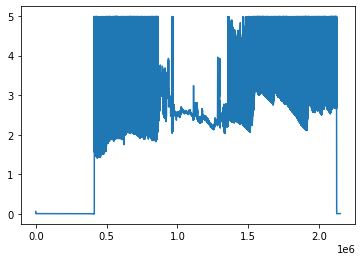

In [13]:
# This is to check the plot of the data, in this example, it looks noisy, so a filter is missing
plt.plot(df.Shimmer_D210_GSR_Skin_Conductance_CAL.values)

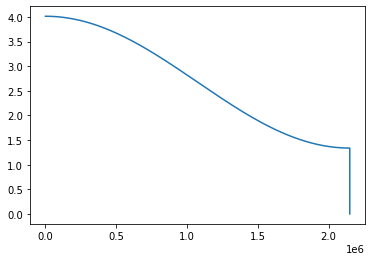

In [14]:
# This plots the decomposed tonic signal
plt.plot(df.tonic)

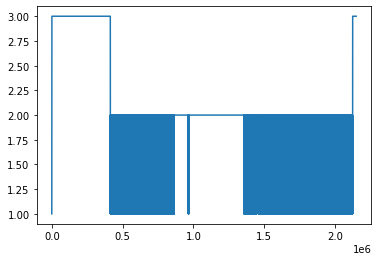

In [15]:
# This plots the decomposed phasic signal, it is noisy as the signal
plt.plot(df.phasic)